# Transformer
Model:
<figure>
<img src=images/transformer/model.png alt="drawing" width="400"/>
<figcaption><b>Reference: <b></figcaption>
</figure>

## Blocks in encoder layer
<figure>
<img src=images/transformer/encoder-layer.png>
</figure>

### Multi-head attention

In [32]:
#pip install tensorflow_datasets
#pip install -U tensorflow-text

In [33]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [61]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

#### Scaled product attention
<figure>
<img src=./images/transformer/self-attention-part.png width= 300/>
<figcaption>Precious Metal Price Prediction Based on Deep Regularization Self-Attention Regression</figcaption>
</figure>

In [35]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True) # Shape = (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    # calculate matmul_qk_v
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

### Masking
Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

In [36]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [37]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### If you want to combind two masks into one mask:

In [38]:
#combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

#### Multi-Head Attention
#### Scaled product attention
<figure>
<img src=./images/transformer/mha_img_original.png width= 500/>
<figcaption>Precious Metal Price Prediction Based on Deep Regularization Self-Attention Regression</figcaption>
</figure>

In [39]:
#create multi-head attention layer
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        #Because for multi-head, head number * depth = multi-head
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        #Set layers for q, k, v
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) # shape = (batch_size, num_heads, seq_len, depth)

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [40]:
# Test multi-head attention (MHA) layer
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

#### Point wise feed forward network

Point wise feed forward network consists of **two fully-connected layers** with a ReLU activation in between.



In [41]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
        ])

In [42]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

#### Construct Encoder layer
<figure>
<img src=images/transformer/encoder-layer.png>
</figure>

In [43]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        #define layers
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2


In [44]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

## Decoder Layer
<figure>
<img src=images/transformer/decoder-layer.png width=200 />
</figure>

- Two multi-head attention
- Three add and norm
- One feed forward

Description from tensorflow:
Each decoder layer consists of sublayers:

- Masked multi-head attention (with look ahead mask and padding mask)
- Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
- Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is **LayerNorm(x + Sublayer(x))**. The normalization is done on the d_model (last) axis.

There are N decoder layers in the transformer.

- Q receives the output from decoder's first attention block
- K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output.

In other words, the decoder predicts the next token by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.



In [45]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)

        # Residual
        out1 = self.layernorm1(attn1 + x)

        # Here in the second attention layer, Q and K are enc_output and V is out1
        attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)

        # Residual
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        
        # Residual
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [46]:
# Trial
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

## It's time to assemble our Encoder
<figure>
<img src=images/transformer/model.png alt="drawing" width="400"/>
<figcaption><b>Reference: <b></figcaption>
</figure>

### Position encoding

In [47]:
def get_angles(pos, i, d_model):
    angle_rate = 1/np.power(10000, (2*(i/2))/np.float32(d_model))
    return pos*angle_rate

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [48]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

(1, 2048, 512)


In [49]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers #how many encoder layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]
        #encoding and position encoding
        x = self.embedding(x) # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x # (batch_size, input_seq_len, d_model)


In [50]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## Decoder
<figure>
<img src=images/transformer/model.png alt="drawing" width="400"/>
<figcaption><b>Reference: <b></figcaption>
</figure>

In [51]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model,  num_heads, dff, target_vocab_size,
    maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        #Here the layer settings are similar as Encoder
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x) # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training )

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
        
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights


In [52]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

## Now we can have the total Transformer model by combind Encoder and Decoder

There are encoder, decoder, which we just constructed, and one final Dense layer for exporting result.

In addition, there is also a function included in class Transformer to create masks.

In [53]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
               super().__init__()
               #Here pe_imput is maximum_position_encoding
               self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                                      input_vocab_size, pe_input, rate)
               
               self.decoder = Decoder(num_layers, d_model, num_heads,
                                      dff,target_vocab_size, pe_target, rate)

               self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp, tar = inputs
        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)
        enc_output = self.encoder(inp, training, enc_padding_mask) 
        # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training,
                                                     look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output, attention_weights

    def create_masks(self, inp, tar):
        #Encoder padding mask
        enc_padding_mask = create_padding_mask(inp)

        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [54]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Adam Optimizer with a custom learning rate scheduler according to the following:
$$
lrate = d^{-0.5}_{model}*min(step_num^{-0.5}, step\_ num \cdot warmup\_ steps^{-1.5})
$$

In [55]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self,step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

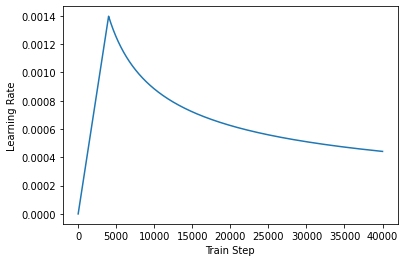

In [56]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss function
**SparseCategoricalCrossentropy**

Since the target sequences are padded, it is important to **apply a padding mask** when calculating the loss.
Here is how to customize the loss function.

In [57]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [68]:
def loss_function(real, pred):
    #mask = real is not 0
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss_ = loss_object(real, pred)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    #find mask and accuracies are both True/False.
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [69]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

### Data preparation

In [60]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

2022-02-03 15:03:52.433856: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:   0%|          | 0/1 [01:08<?, ? url/s]
Extraction completed...: 0 file [01:08, ? file/s]
Dl Completed...:   0%|          | 0/1 [01:08<?, ? url/s]


KeyboardInterrupt: 

In [62]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

NameError: name 'train_examples' is not defined

### Text Tokenizations (use google's tokenizer)

In [63]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

196608/184801 [===============================] - 0s 1us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [64]:
tokenizers = tf.saved_model.load(model_name)

2022-02-03 15:06:53.891237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 15:06:53.900949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [65]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

### Data pipline


In [66]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

NameError: name 'train_examples' is not defined

In [67]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

NameError: name 'train_examples' is not defined

In [59]:
# Set hyper parameters
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

#Create Transformer model
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

# Checkpoints
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

NameError: name 'tokenizers' is not defined

## Setting Train Step

In [70]:
EPOCHS = 20
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

## After Training, we can create the translator and apply the model to see the result

In [73]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=20):
        # input sentence is portuguese, hence adding the start and end token
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

        encoder_input = sentence

        # as the target is english, the first token to the transformer should be the
        # english start token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a python list) so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions, _ = self.transformer([encoder_input, output], training=False)

        # select the last token from the seq_len dimension
            predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

            predicted_id = tf.argmax(predictions, axis=-1)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # output.shape (1, tokens)
        text = tokenizers.en.detokenize(output)[0]  # shape: ()

        tokens = tokenizers.en.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop. So recalculate them outside
        # the loop.
        _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

        return text, tokens, attention_weights

In [74]:
translator = Translator(tokenizers, transformer)
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

NameError: name 'transformer' is not defined

## Attention Plot

In [ ]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [75]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

In [ ]:
translated_tokens

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

## For multiple head attention visualization

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence, translated_tokens, attention_weights['decoder_layer4_block2'][0])

In [ ]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Export model for application
That inference model is working, so next you'll export it as a tf.saved_model.

To do that, wrap it in yet another tf.Module sub-class, this time with a tf.function on the __call__ method:

In [76]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, 
     tokens,
     attention_weights) = self.translator(sentence, max_length=100)

    return result

In [ ]:
translator = ExportTranslator(translator)
translator("este é o primeiro livro que eu fiz.").numpy()
tf.saved_model.save(translator, export_dir='translator')
reloaded = tf.saved_model.load('translator')